<a href="https://colab.research.google.com/github/kasalehi/LogistRegression_with_Tensorflow/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lets hands on transfer learning
## in this learning we are going to go through two main methosd effiecnt04 and resnet tand then try to use feature_extraction method to freezing all layers and just change the output layers for our case and see how mush we can boost the accuracy

### some note regarding this workbook :
* we are going to use tensorflow hub and tf_keras in order to added tensorflowkeraslayer for our feature extraction
* we are going to create the tensorboard callback function to save our model_logs

🔔: there are two other main methods in transfer learnig:
* scalling
* fine tunning : in this method some layers are unfrozen and based on our business case we can adjust them


# Among all those three models the feature extraction one is more affordable and applicable

In [1]:
# lets call allthose modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-09-29 02:30:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.129.207, 173.194.64.207, 172.217.214.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.129.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   233MB/s    in 0.7s    

2025-09-29 02:30:16 (233 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
import zipfile
files=zipfile.ZipFile('data.zip')
files.extractall()
files.close()

In [7]:
# lets make the data more snesible
## let create the directory for the our data train and test
train_dir='data/train/'
test_dir='data/test/'

train_gen=ImageDataGenerator(rescale=1/255)
test_gen=ImageDataGenerator(rescale=1/255)


# lets define the normalize and rescale  train and test

train=train_gen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    class_mode='categorical', # Changed class_mode to 'sparse'
    seed=10

)

test=test_gen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    class_mode='categorical', # Changed class_mode to 'sparse'
    seed=10

)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [8]:
# now its time to call models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
# lets define the tensorboard to save the model logs to track in future
def tensorboard_save(model_path,model_name ):
  """
  ythe folowing layers callbacks help to save the log files of both modle in terms of monitoring the model
  """

  log_dir=model_path + '/' + model_name
  saving_model=tf_keras.callbacks.TensorBoard(log_dir=log_dir)
  return saving_model

In [11]:
# lets define the function for feature extraction

def feature_extraction(model_url, calss_num=10):
  feature_layers=hub.KerasLayer(
    model_url,
    trainable=False,
    input_shape=(224,224,3),

  )

  return feature_layers

In [12]:
# now lets creating model

tf.random.set_seed(42)

model=tf_keras.models.Sequential([
    feature_extraction(model_url=resnet_url, calss_num=10),
    tf_keras.layers.Dense(10, activation='softmax')


])

# let copile the model

model.compile(
    loss=tf_keras.losses.categorical_crossentropy,
    optimizer=tf_keras.optimizers.Adam(),
    metrics=['accuracy']
)

history=model.fit(train,
                  steps_per_epoch=len(train),
          validation_data=(test),
                  validation_steps=len(test),
          epochs=5,
          callbacks=[tensorboard_save(model_path='Models', model_name='resnet')]
          )

Epoch 1/5
24/24 [==============================] - 173s 7s/step - loss: 1.9365 - accuracy: 0.3693 - val_loss: 1.1954 - val_accuracy: 0.6240
Epoch 2/5
24/24 [==============================] - 107s 5s/step - loss: 0.9108 - accuracy: 0.7253 - val_loss: 0.8434 - val_accuracy: 0.7316
Epoch 3/5
24/24 [==============================] - 107s 5s/step - loss: 0.6202 - accuracy: 0.8253 - val_loss: 0.7482 - val_accuracy: 0.7524
Epoch 4/5
24/24 [==============================] - 108s 5s/step - loss: 0.4808 - accuracy: 0.8827 - val_loss: 0.6958 - val_accuracy: 0.7752
Epoch 5/5
24/24 [==============================] - 107s 5s/step - loss: 0.3809 - accuracy: 0.9160 - val_loss: 0.6788 - val_accuracy: 0.7764


<Axes: >

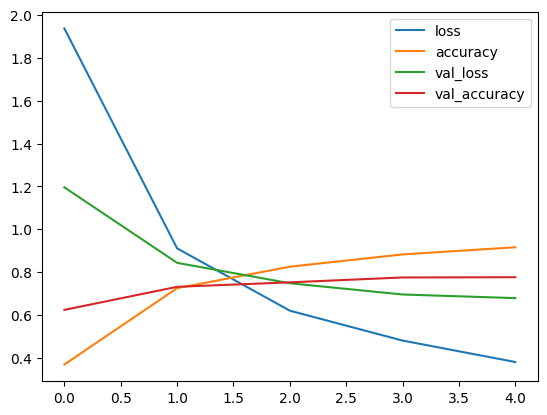

In [13]:
# lets see the loss function via visualization
pd.DataFrame(history.history).plot()

In [15]:
# # l3ts see the evaluation and accutacy
# model.evaluate(test)

<Figure size 1000x1000 with 0 Axes>

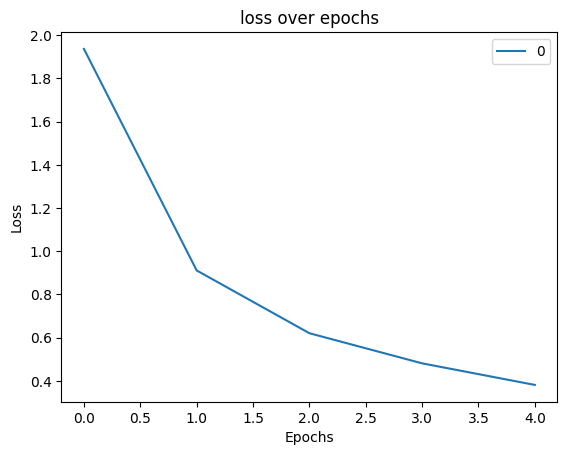

In [22]:
# now lets visualize the loss function
plt.figure(figsize=(10,10))
pd.DataFrame(history.history['loss']).plot()
plt.title('loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
